# 投资者情绪专题
在短暂的学习生涯中,窥见了学术前沿中一些令人兴奋的领域...这使我如此渴望接触更大的世界,在研究中"讲好中国故事"!

## 1.数据准备

In [1]:
import sys
import os
import cudf  #CUDA计算
import pandas as pd

# 自行编写的包
sys.path.append('/home/ubuntu/notebook/Investor-Sentiment')
sys.path.append('/usr/local/stata17/utilities')
from loader.findata_loader import Loader
from utils.sql import DB

# Stata
from pystata import config  # noqa

config.init('mp')
# ------------------------------数据集路径----------------------------------#
DATASETS_PATH = '/data/DataSets/investor_sentiment/'


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 8-core , expiring  1 Jan 2025
Serial number: 501709301094
  Licensed to: Colin's Stata
               Love U

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


### 媒体情绪数据

In [2]:
def extract_pdate_mediasent() -> cudf.DataFrame:
    """
    提取推文中的情绪,自然日期
    :return:
    """
    # 提取
    pd.options.mode.chained_assignment = None  #忽略警告
    df_select = pd.read_sql(
            "SELECT id,p_date, title_neg, cover_neg, biz FROM WECAHT_DATA.articles_tag "
            "WHERE mov=10 AND biz in ('MjM5MzMwNjM0MA==','MjM5NzQ5MTkyMA==','MjY2NzgwMjU0MA==','MjY2NzgwMjU0MA==')",
            con=DB().ENGINE,
            parse_dates=["p_date"])

    # 筛选
    df_select['p_date'] = df_select['p_date'].dt.strftime('%Y%m%d').astype('uint32')
    df_select = df_select.query("p_date>=20140101")

    # 阈值处理
    df_select['title_flag'] = df_select['title_neg'].apply(lambda x: 1 if x > 0.5 else 0)
    df_select['cover_flag'] = df_select['cover_neg'].apply(lambda x: 1 if x > 0.5 else 0)

    # 每日情绪
    df_select['day_article'] = df_select.groupby('p_date')['id'].transform('count')

    df_select['tex_neg'] = df_select['title_flag'] / df_select['day_article']
    df_select['img_neg'] = df_select['cover_flag'] / df_select['day_article']

    # 时间序列
    df_select = df_select.groupby(['p_date', ], as_index=False).first()
    # 筛选
    return cudf.from_pandas(df_select[['p_date', 'img_neg', 'tex_neg']]).set_index('p_date').sort_index().reset_index()


extract_pdate_mediasent()

,p_date,img_neg,tex_neg
0,20140101,0.0,0.000000
1,20140102,0.0,0.000000
2,20140103,0.0,0.333333
3,20140104,0.0,0.000000
4,20140105,0.0,0.000000
...,...,...,...
3069,20220623,0.0,0.000000
3070,20220624,0.0,0.142857
3071,20220625,0.0,0.000000
3072,20220626,0.0,0.000000


### 股吧数据

In [3]:
df_forum = (
        cudf.read_parquet(
                DATASETS_PATH + 'FORUM_SENT_TRANS.parquet',
                columns=['PostDate', 'Stockcode', 'PostSource', 'PositiveSentIndexA', 'PositiveSentIndexB', 'TotalPosts', 'AvgReadings',
                         'AvgComments', 'AvgPositThumbUps'])
        .query("PostDate>=20140101")

)

#
df_forum.set_index(['PostDate', 'Stockcode']).sort_index()

PostSource PositiveSentIndexA PositiveSentIndexB  \
PostDate Stockcode                                                     
20140101 000030.SZ           1               <NA>               <NA>   
         000030.SZ           1               <NA>               <NA>   
         000034.SZ           1               <NA>               <NA>   
         000034.SZ           1               <NA>               <NA>   
         000043.SZ           1               <NA>               <NA>   
...                        ...                ...                ...   
20211016 900948.SH           1               <NA>               <NA>   
         900952.SH           1               <NA>               <NA>   
         900953.SH           1               <NA>               <NA>   
         900955.SH           1               <NA>               <NA>   
         900957.SH           1               <NA>               <NA>   

                    TotalPosts AvgReadings AvgComments AvgPositThumbUps  
PostDate Stockcode                                                       
20140101 000030.SZ           0        <NA>        <NA>             <NA>  
         000030.SZ           0        <NA>        <NA>             <NA>  
         000034.SZ           0        <NA>        <NA>             <NA>  
         000034.SZ           0        <NA>        <NA>             <NA>  
         000043.SZ           0        <NA>        <NA>             <NA>  
...                        ...         ...         ...              ...  
20211016 900948.SH           0        <NA>        <NA>             <NA>  
         900952.SH           0        <NA>        <NA>             <NA>  
         900953.SH           0        <NA>        <NA>             <NA>  
         900955.SH           0        <NA>        <NA>             <NA>  
         900957.SH           0        <NA>        <NA>             <NA>  

[11846133 rows x 7 columns]

### 日期映射

In [4]:
def extract_map_date() -> cudf.DataFrame:
    df_mapdate = pd.read_sql_table('map_date', DB().ENGINE, 'FIN_BASIC', parse_dates=['nature_date', 'map_l0'])[['nature_date', 'map_l0']]
    df_mapdate['nature_date'] = df_mapdate['nature_date'].dt.strftime('%Y%m%d').astype('uint32')
    df_mapdate.dropna(axis=0, subset=['map_l0'], inplace=True)
    df_mapdate['map_l0'] = df_mapdate['map_l0'].dt.strftime('%Y%m%d').astype('uint32')
    return cudf.from_pandas(df_mapdate.rename(columns={'nature_date': 'p_date', 'map_l0': 'trade_date'}))


extract_map_date()

,p_date,trade_date
0,20140101,20140102
1,20140102,20140102
2,20140103,20140103
3,20140104,20140106
4,20140105,20140106
...,...,...
3235,20221110,20221110
3236,20221111,20221111
3237,20221112,20221114
3238,20221113,20221114


### 指数面板数据

In [5]:
df_basic = cudf.read_parquet(f'{DATASETS_PATH}IDX_PANEL_BASIC_WUGUI.parquet')[['close']].query("trade_date>=20131231").reset_index()
df_basic['close_l1'] = df_basic.groupby(by=['ts_code'], as_index=False, sort=True)['close'].shift(1)
df_basic['close_chg'] = 100 * ((df_basic['close'] / df_basic['close_l1']) - 1)
df_basic['time'] = df_basic.groupby(by=['ts_code'])['trade_date'].rank()
df_basic

,trade_date,ts_code,close,close_l1,close_chg,time
0,20131231,000001.SH,2115.9800,<NA>,<NA>,1.0
1,20131231,000010.SH,5040.2700,<NA>,<NA>,1.0
2,20131231,000015.SH,1681.4600,<NA>,<NA>,1.0
3,20131231,000016.SH,1574.7800,<NA>,<NA>,1.0
4,20131231,000300.SH,2330.0300,<NA>,<NA>,1.0
...,...,...,...,...,...,...
28251,20221209,000985.SH,4973.3481,4947.6296,0.519814579,2172.0
28252,20221209,399001.SZ,11501.5800,11389.79,0.981493074,2175.0
28253,20221209,399005.SZ,7674.1500,7610.6,0.835019578,2175.0
28254,20221209,399006.SZ,2420.6300,2411.81,0.365700449,2175.0


## 2.投资者情绪指标计算

计算加权影响力,参数为影响力系数,点赞评论阅读

In [6]:
# 5311 5%A 10%B
# 1000 9100  X
# 1000 X

# pdate
A, B, C, D = 0.6, 0.2, 0.1, 0.1
# tdate
A2, B2, C2, D2 = 0.6, 0.2, 0.1, 0.1

In [7]:
def cal_investor_sentiment(df: cudf.DataFrame, a, b, c, d) -> cudf.DataFrame:
    """
    计算加权投资者情绪
    :return:
    """

    # 每日总量
    df['DayTotalPosts'] = df.groupby(['PostDate', ])['TotalPosts'].transform('sum')
    df['DayAvgReadings'] = df.groupby(['PostDate', ])['AvgReadings'].transform('sum')
    df['DayAvgComments'] = df.groupby(['PostDate', ])['AvgComments'].transform('sum')
    df['DayAvgPositThumbUps'] = df.groupby(['PostDate', ])['AvgPositThumbUps'].transform('sum')

    # 加权因子总量
    df['DayTotalPostsFactor'] = df['TotalPosts'] / df['DayTotalPosts']
    df['DayAvgReadingsFactor'] = df['AvgReadings'] / df['DayAvgReadings']
    df['DayAvgCommentsFactor'] = df['AvgComments'] / df['DayAvgComments']
    df['DayAvgPositThumbUpsFactor'] = df['AvgPositThumbUps'] / df['DayAvgPositThumbUps']

    # 个股加权情绪因子
    df['PositiveSentIndexAFactor'] = (
            (df['DayTotalPostsFactor'] * a + df['DayAvgReadingsFactor'] * b +
             df['DayAvgCommentsFactor'] * c + df['DayAvgPositThumbUpsFactor'] * d)
            * df['PositiveSentIndexA']
    )

    df['PositiveSentIndexBFactor'] = (
            (df['DayTotalPostsFactor'] * a + df['DayAvgReadingsFactor'] * b +
             df['DayAvgCommentsFactor'] * c + df['DayAvgPositThumbUpsFactor'] * d)
            * df['PositiveSentIndexB']
    )

    # 每日情绪因子
    df['DayPositiveSentIndexA'] = df.groupby(['PostDate'])['PositiveSentIndexAFactor'].transform('sum')
    df['DayPositiveSentIndexB'] = df.groupby(['PostDate'])['PositiveSentIndexBFactor'].transform('sum')

    # 转换为时间序列数据
    df_time = df.groupby(['PostDate', ], as_index=False).first()[
        ['PostDate', 'DayPositiveSentIndexA', 'DayPositiveSentIndexB',
         'DayTotalPosts', 'DayAvgReadings', 'DayAvgComments', 'DayAvgPositThumbUps']]
    df_time.columns = ['p_date', 'IndexA', 'IndexB', 'Posts', 'Readings', 'Comments', 'ThumbUps']
    return df_time

# cal_investor_sentiment(df_forum, A, B, C, D)

### 合并和映射

In [8]:
def merge_tdate_media_investor() -> cudf.DataFrame:
    """
    合并论坛和媒体情绪,交易日期
    """
    df_map = cudf.merge(
            cal_investor_sentiment(df_forum, A2, B2, C2, D2),
            extract_map_date(),
            on=['p_date'], how='left'

    )

    # 计算平均指标
    df_map['IndexA'] = df_map.groupby('trade_date', as_index=False)['IndexA'].transform('mean')
    df_map['IndexB'] = df_map.groupby('trade_date', as_index=False)['IndexB'].transform('mean')
    df_map['Posts'] = df_map.groupby('trade_date', as_index=False)['Posts'].transform('mean')
    df_map['Readings'] = df_map.groupby('trade_date', as_index=False)['Readings'].transform('mean')
    df_map['Comments'] = df_map.groupby('trade_date', as_index=False)['Comments'].transform('mean')
    df_map['ThumbUps'] = df_map.groupby('trade_date', as_index=False)['ThumbUps'].transform('mean')

    # 时间序列
    df_map = df_map.groupby('trade_date').first().sort_index().reset_index()

    # 合并
    df_merge = cudf.merge(Loader().get_time_series().reset_index(), df_map, on='trade_date', how='left')

    # 单位
    df_merge['Readings'] = df_merge['Readings'] / 100

    return df_merge.set_index('trade_date').sort_index().reset_index()


def merge_pdate_media_investor() -> cudf.DataFrame:
    """
    发布日期定义的合并
    :return:
    """
    # 合并
    df_merge = cudf.merge(extract_pdate_mediasent(), cal_investor_sentiment(df_forum, A, B, C, D), on='p_date',
                          how='left')
    # 单位
    df_merge['Readings'] = df_merge['Readings'] / 100

    # 改名字方便变量
    return df_merge.rename(columns={'p_date': 'trade_date'}).set_index('trade_date').sort_index().reset_index()


merge_pdate_media_investor()

,trade_date,img_neg,tex_neg,IndexA,IndexB,Posts,Readings,Comments,ThumbUps
0,20140101,0.0,0.000000,<NA>,<NA>,0,<NA>,<NA>,<NA>
1,20140102,0.0,0.000000,<NA>,<NA>,0,<NA>,<NA>,<NA>
2,20140103,0.0,0.333333,NaN,NaN,4,2147.58,684.0,0.0
3,20140104,0.0,0.000000,<NA>,<NA>,0,<NA>,<NA>,<NA>
4,20140105,0.0,0.000000,<NA>,<NA>,1,96.94,22.0,<NA>
...,...,...,...,...,...,...,...,...,...
3069,20220623,0.0,0.000000,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3070,20220624,0.0,0.142857,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3071,20220625,0.0,0.000000,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3072,20220626,0.0,0.000000,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [9]:
merge_tdate_media_investor()

,trade_date,img_neg,tex_neg,riskfree_return,p_date,IndexA,IndexB,Posts,Readings,Comments,ThumbUps
0,20140102,0.0,0.0,0.015460,20140101,<NA>,<NA>,0.0,<NA>,<NA>,<NA>
1,20140103,0.0,0.333333,0.015461,20140103,NaN,NaN,4.0,2147.58,684.0,0.0
2,20140106,0.285714,0.142857,0.015481,20140104,NaN,NaN,0.666666667,113.26,23.5,0.0
3,20140107,0.0,0.333333,0.015489,20140107,<NA>,<NA>,0.0,<NA>,<NA>,<NA>
4,20140108,0.333333,0.0,0.015506,20140108,<NA>,<NA>,0.0,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
2210,20221212,<NA>,<NA>,0.006314,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2211,20221213,<NA>,<NA>,0.006342,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2212,20221214,<NA>,<NA>,0.006383,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2213,20221215,<NA>,<NA>,0.006447,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [10]:
# df_var = (
#         cudf.merge(
#                 df_basic,
#                 (cudf.merge(cudf.from_pandas(extract_pdate_wcsentiment()),
#                             cal_investor_sentiment(df_forum, A, B, C, D),
#                             on='trade_date', how='left')),
#                 on='trade_date', how='left'
#         )
#
# )
# df_var = df_var.to_pandas().astype(dtype={'trade_date': 'str'}).sort_values('trade_date')
# df_var

In [11]:
# 交易日期和自然日期
df_ols_pdate = merge_pdate_media_investor()
df_ols_tdate = merge_tdate_media_investor()

# 调整格式
df_ols_pdate = df_ols_pdate.to_pandas().astype(dtype={'trade_date': 'str'}).sort_values('trade_date')
df_ols_tdate = df_ols_tdate.to_pandas().astype(dtype={'trade_date': 'str'}).sort_values('trade_date')


### 描述性统计

In [12]:
# @formatter:off

In [13]:
%%stata -d df_ols_pdate -force
sum


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
  trade_date |          0
     img_neg |      3,074    .0461153    .1466362          0          1
     tex_neg |      3,074    .0551386     .162986          0          1
      IndexA |      2,310    .3129879    .3238659  -.3196962          1
      IndexB |      2,310    .2005353    .3025481  -.6873239   1.820648
-------------+---------------------------------------------------------
       Posts |      2,820    31940.27    56218.14          0     266025
    Readings |      2,586    123132.2    504281.4        .02    7025052
    Comments |      2,586    15319.71    100701.7          0    1786412
    ThumbUps |      2,448     10492.6    72697.92          0    1233104


In [14]:
%%stata -d df_ols_pdate -force -gw 12in -gh 6in  -qui -nogr

//设定时间序列
ge dt = date(trade_date, "YMD")
format dt %tdCCYYNNDD
tsset dt

//绘制股吧数据变化图
graph drop _all
foreach var in Posts Readings Comments ThumbUps    {
    twoway (tsline `var' ,lwidth(vvvthin)) ,name(`var',replace) xtitle("")  ylabel(, nogrid) scheme(sj) xsize(10)
}

//投资者情绪折线图
twoway (tsline IndexB ) ,name(time_change,replace) ///
xtitle(Date,margin(medium)) xlabel(, labgap(medium)) ///
ytitle(Investor Sentiment) ylabel(, nogrid) scheme(sj)

//投资者情绪分布图
histogram IndexB, name(distribution,replace) ///
xtitle(Investor Sentiment,margin(medium)) xlabel(, labgap(medium)) ///
ylabel(, nogrid)  scheme(sj) ///
normal normopts(lpattern(dash))

图片合成

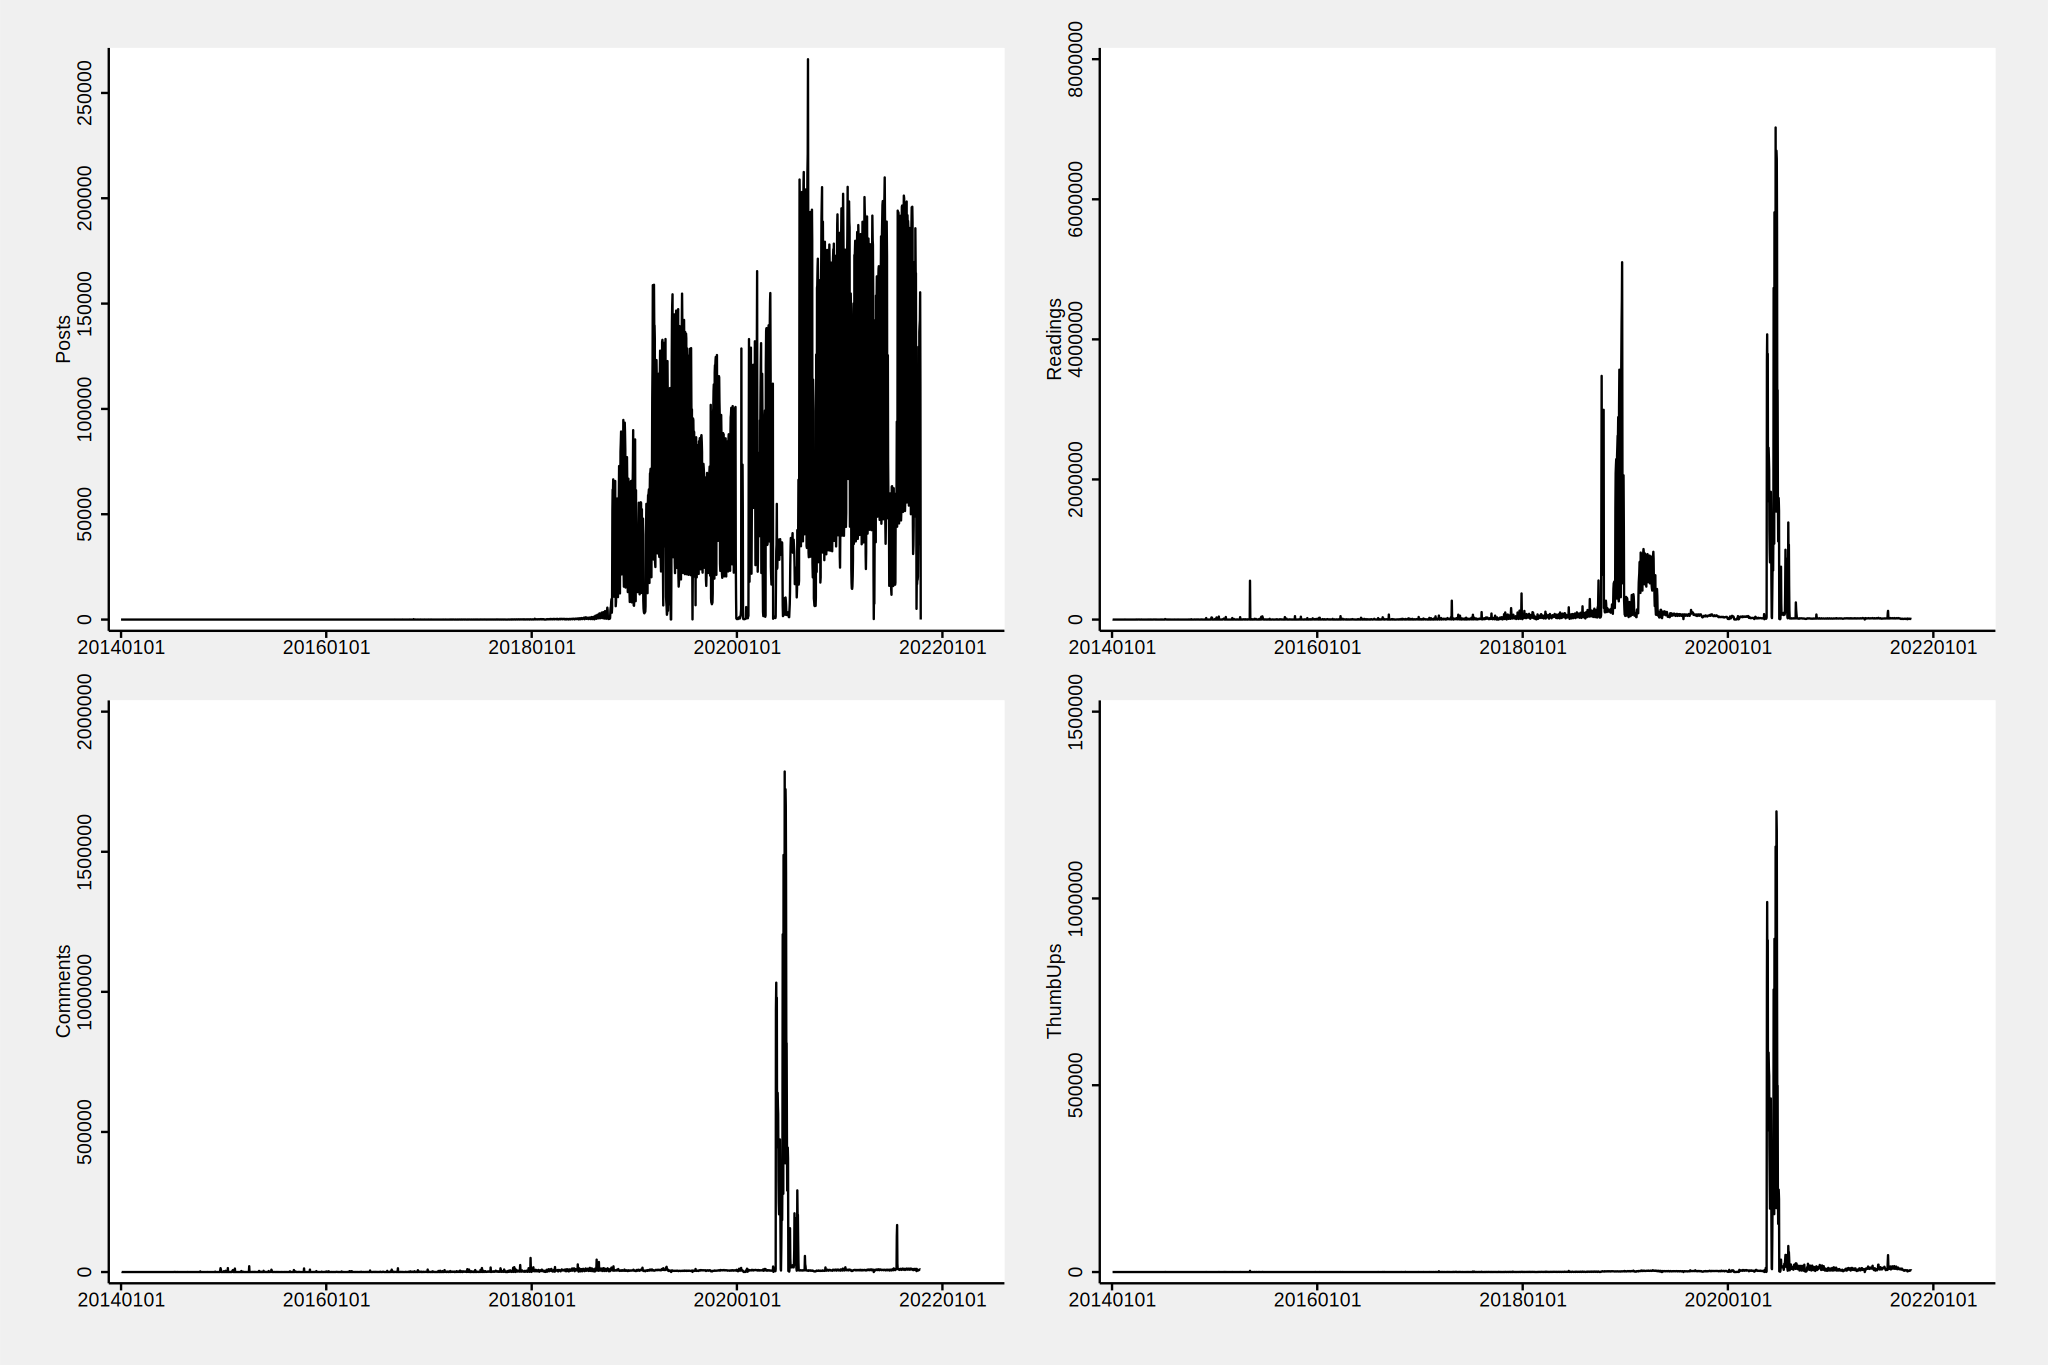

In [15]:
%%stata  -gw 12in -gh 8in
graph combine Posts Readings Comments ThumbUps , name(c1,replace) xcommon scale(0.5) scheme(sj)

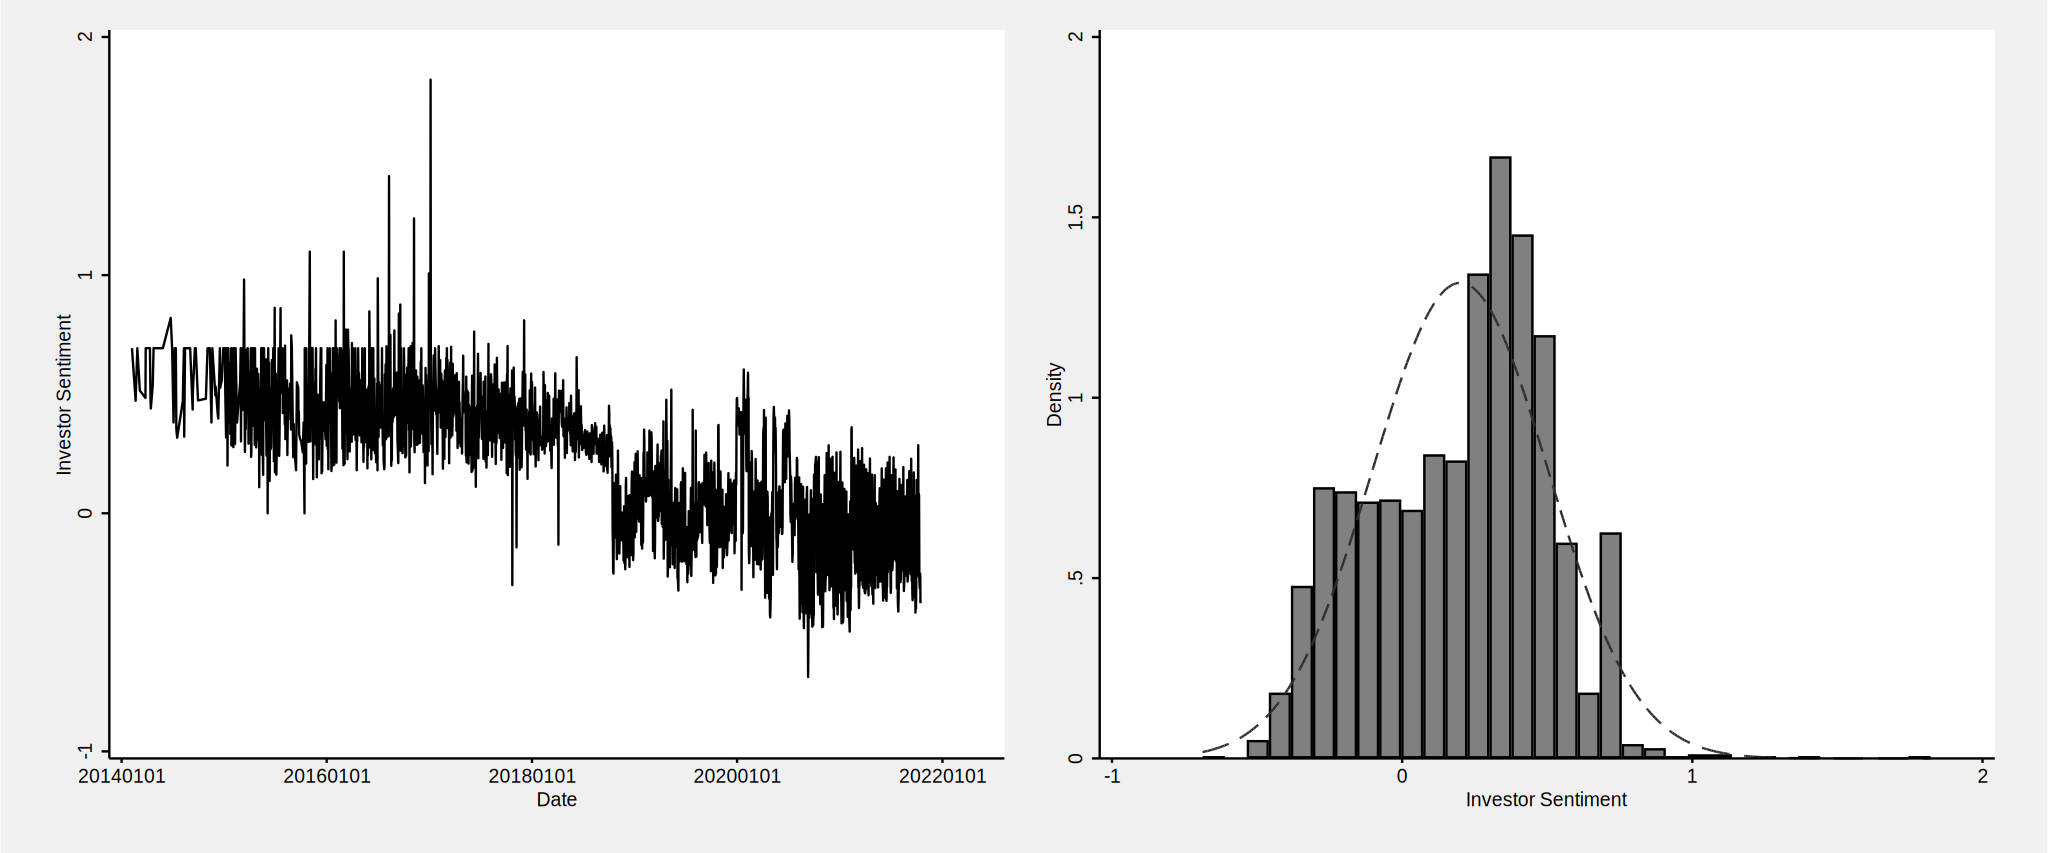

In [16]:
%%stata -gw 12in -gh 5in
graph combine time_change distribution, name(c2,replace) scale(0.5)  scheme(sj)

## 3.媒体情绪对投资者情绪的影响

### 线性回归分析-发布日期

In [21]:
%%stata -d df_ols_pdate -force
//清除
est clear

//设定时间序列
ge time=_n
tsset time

//缩尾
winsor2 IndexA, cut(1 99)
winsor2 IndexB, cut(1 99)

//外生变量
ge dt = date(trade_date, "YMD")
format dt %tdCCYYNNDD
ge year=year(dt)

//变量对数处理
ge lnPosts=ln(Posts)
ge lnReadings=ln(Readings)
ge lnComments=ln(Comments)
ge lnThumbUps=ln(ThumbUps)

//图像情绪回归
rename(img_neg) (media_neg)
eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r


rename(media_neg) (img_neg)

//文本情绪回归
rename(tex_neg) (media_neg)
eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r


rename(media_neg) (tex_neg)

//增加固定效应
estadd local Year "Yes" : *

//输出结果
esttab using Investor-Sentiment/outputs/media_to_investor ,r type ///
keep(L.*) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
title("Table MediaSent to InvestorSent") mtitle("InvestorSent A" "InvestorSent B" "InvestorSent A" "InvestorSent B") ///
mgroups("img_neg" "tex_neg", pattern(1 0 1 0 )) ///
nogaps  b(%12.4f)


. //清除
. est clear

. 
. //设定时间序列
. ge time=_n

. tsset time

Time variable: time, 1 to 3074
        Delta: 1 unit

. 
. //缩尾
. winsor2 IndexA, cut(1 99)

. winsor2 IndexB, cut(1 99)

. 
. //外生变量
. ge dt = date(trade_date, "YMD")

. format dt %tdCCYYNNDD

. ge year=year(dt)

. 
. //变量对数处理
. ge lnPosts=ln(Posts)
(488 missing values generated)

. ge lnReadings=ln(Readings)
(488 missing values generated)

. ge lnComments=ln(Comments)
(492 missing values generated)

. ge lnThumbUps=ln(ThumbUps)
(764 missing values generated)

. 
. //图像情绪回归
. rename(img_neg) (media_neg)

. eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est1 stored)

. eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est2 stored)

. 
. 
. rename(media_neg) (img_neg)

. 
. //文本情绪回归
. rename(tex_neg) (media_neg)

. eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est3 stored)

. est

### 线性回归分析-交易日期

In [18]:
%%stata -d df_ols_tdate -force
//清除
est clear

//设定时间序列
ge time=_n
tsset time

//缩尾
winsor2 IndexA, cut(1 99)
winsor2 IndexB, cut(1 99)

//外生变量
ge dt = date(trade_date, "YMD")
format dt %tdCCYYNNDD
ge year=year(dt)

//变量对数处理
ge lnPosts=ln(Posts)
ge lnReadings=ln(Readings)
ge lnComments=ln(Comments)
ge lnThumbUps=ln(ThumbUps)

//图像情绪回归
rename(img_neg) (media_neg)
eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year if year>=2018 ,r

eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year if year>=2018 ,r
rename(media_neg) (img_neg)

//文本情绪回归
rename(tex_neg) (media_neg)
eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year if year>=2018 ,r

eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year if year>=2018 ,r
rename(media_neg) (tex_neg)

//增加固定效应
estadd local Year "Yes" : *

//输出结果
esttab using Investor-Sentiment/outputs/media_to_investor ,r type ///
keep(L.*) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
title("Table MediaSent to InvestorSent") ///
mgroups("img_neg" "tex_neg", pattern(1 0 0 0 1 0 0 0 )) ///
nogaps compress b(%12.4f)


. //清除
. est clear

. 
. //设定时间序列
. ge time=_n

. tsset time

Time variable: time, 1 to 2215
        Delta: 1 unit

. 
. //缩尾
. winsor2 IndexA, cut(1 99)

. winsor2 IndexB, cut(1 99)

. 
. //外生变量
. ge dt = date(trade_date, "YMD")

. format dt %tdCCYYNNDD

. ge year=year(dt)

. 
. //变量对数处理
. ge lnPosts=ln(Posts)
(401 missing values generated)

. ge lnReadings=ln(Readings)
(401 missing values generated)

. ge lnComments=ln(Comments)
(403 missing values generated)

. ge lnThumbUps=ln(ThumbUps)
(578 missing values generated)

. 
. //图像情绪回归
. rename(img_neg) (media_neg)

. eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est1 stored)

. eststo: qui reg IndexA L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year if year>=2018 ,r
(est2 stored)

. 
. eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est3 stored)

. eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComme

## 4.投资者情绪对股票市场的影响

In [19]:
# %%stata -d df_var -force
# est clear
#
# //设定面板数据
# encode ts_code,gen(id)
# xtset id time
#
# //增加固定效应
# ge dt = date(trade_date, "YMD")
# format dt %tdCCYYNNDD
# ge year=year(dt)
#
# //增加平方项
# ge close_chg_s=close_chg*close_chg
#
# //分组VAR回归
# by id, sort : eststo: qui var close_chg IndexB close_chg_s, lags(1/5) exog(year)
#
# esttab , keep(close_chg:L*.IndexB) nogaps compress b(%12.4f) star(* 0.1 ** 0.05 *** 0.01)